# Library Import

In [1]:
import matplotlib as mlp
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from cycler import cycler 
import numpy as np
import json
import pandas as pd

# Chart Option 

In [2]:
OPT_STYLE = 'style'
OPT_COLOR_MAP = 'axes.color_map'
OPT_COLOR_PALLETE = 'axes.color_pallete'
OPT_COLOR_ALPHA = 'axes.color_alpha'
OPT_PROP_CYCLE = 'axes.prop_cycle'
OPT_BAR_WIDTH = 'axes.bar_width'
OPT_BAND_COLOR = 'axes.band_color'
OPT_BAND_COLOR_ALPHA = 'axes.band_color_alpha'

non_mlp_options = [
    OPT_STYLE, 
    OPT_COLOR_MAP, 
    OPT_COLOR_PALLETE, 
    OPT_COLOR_ALPHA, 
    OPT_BAR_WIDTH,
    OPT_BAND_COLOR,
    OPT_BAND_COLOR_ALPHA
]

def set_color_map(values, alpha=1.0, max_legend_cnt=1):
    color_map = []
    color_norm = colors.Normalize(vmin=0, vmax=max_legend_cnt)
    scalar_map = cmx.ScalarMappable(norm=color_norm,
                                   cmap=values)
    color_map = [scalar_map.to_rgba(i, alpha=alpha) for i in range(max_legend_cnt)]
    return color_map

def set_cycler(json_dic,max_legend_cnt=1): 
    # Set color cycler
    color_map = []
    alpha = 1.0
    if OPT_COLOR_ALPHA in json_dic.keys():
        alpha = json_dic[OPT_COLOR_ALPHA]
    if OPT_COLOR_MAP in json_dic.keys():
        color_map = set_color_map(json_dic[OPT_COLOR_MAP], alpha, max_legend_cnt)
    if OPT_COLOR_PALLETE in json_dic.keys():
        color_map = [colors.to_rgba(val, alpha=alpha) for val in json_dic[OPT_COLOR_PALLETE]]
    if color_map:
        mlp.rcParams[OPT_PROP_CYCLE] = cycler(color = color_map)
    
def set_mlp_option(json_dic):
    for key in json_dic.keys():
        if key not in non_mlp_options:
            mlp.rcParams[key] = json_dic[key]
            
def set_bar_width(x_size, x_cnt, legend_cnt):
    return (x_size / (x_cnt * legend_cnt))*2

### Merge Data 

In [3]:
def merge_legend(X, Y, legends):
    unique_x = np.unique(X)
    unique_legend = np.unique(legends)
    
    df_merge = pd.DataFrame(
        {
            'X': unique_x
        }
    )
    
    for legend in unique_legend:
        df = pd.DataFrame (
            {
                'X' : X[np.where(legends==legend)], 
                'Y_' + legend : Y[np.where(legends==legend)]
            }
        )
        df_merge = df_merge.merge(df, how='left', on=['X'])
        
    return df_merge

# Draw Chart

In [4]:
def draw_bar_chart(X, Y, title, legend, sequence, options):
    if legend.size != 0:
        u_legend = np.unique(legend)
        u_legend_cnt = len(u_legend)
    else:
        u_legend = np.array([title])
        u_legend_cnt = 1
    
    # Set style options
    option_dict = json.loads(options)
    
    if OPT_STYLE in option_dict.keys():
        plt.style.use(option_dict[OPT_STYLE])

    if (OPT_COLOR_MAP in option_dict.keys()
        or OPT_COLOR_PALLETE in option_dict.keys()):
        set_cycler(option_dict, u_legend_cnt)
        
    set_mlp_option(option_dict)
    
    # Draw chart and bind data    
    fig, ax = plt.subplots()
    ax.set_title(title)
    
    if sequence.size != 0:
        seq = []
        for i in range(u_legend_cnt):
            seq.append(sequence[np.where(legend==u_legend[i])][0])
        sorted_seq_index = np.argsort(seq)
    else:
        seq = np.arange(u_legend_cnt)
        sorted_seq_index = np.arange(u_legend_cnt)
        
    df = merge_legend(X, Y, legend) 
    
    # Set bar width
    if (OPT_BAR_WIDTH in option_dict.keys()):
        axes_barwidth = option_dict[OPT_BAR_WIDTH]
    else:
        bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        axes_barwidth = set_bar_width(bbox.width, df.shape[0], u_legend_cnt)    
    
    idx = 0 
    for i in sorted_seq_index:
        subX = df['X']
        subY = df['Y_' + u_legend[i]]
        
        ax.bar(np.array(df.index.tolist()) + (axes_barwidth * idx), subY, 
                axes_barwidth, 
                label=u_legend[i])
        idx = idx + 1
    ax.set_xticks(np.array(df.index.tolist()) + axes_barwidth/u_legend_cnt)    
    ax.set_xticklabels(df['X'])
        
    ax.legend()
    plt.show()

# Get Stock Price in YAHOO  

In [5]:
from pandas_datareader import data
import pandas as pd
import pprint
from datetime import datetime
def getStockHistory(companyCode, fromDate, toDate):
    dataSource = 'yahoo'
    storeList = []
    ticker = companyCode
    print('===========>Call ' + ticker)
    try:
        start = pd.to_datetime(fromDate).date()
        end = pd.to_datetime(toDate).date()
        panel_data = data.DataReader(ticker, dataSource, start, end)
    except:
        print(ticker + ' ommit')
        return
    panel_data = panel_data.transpose()
    if len(panel_data) > 0:
        for stock_data in panel_data:
                storeDic = {}
                #print stock_data
                storeDic["code"] = ticker
                storeDic["s_date"] = stock_data
                #storeDic["adj_close"] = stock_data["Adj Close"]
                storeDic["s_close"] = panel_data[stock_data]["Close"]
                storeDic["s_open"] = panel_data[stock_data]["Open"]
                storeDic["s_high"] = panel_data[stock_data]["High"]
                storeDic["s_low"] = panel_data[stock_data]["Low"]
                storeDic["s_volume"] = panel_data[stock_data]["Volume"]
                storeList.append(storeDic)
                #pprint.pprint(storeDic)
    else:
        print (ticker + ' does not exist')
    print ('===========>END ' + ticker)   
    
    return storeList

###  015260.KS price

In [6]:
storeList1 = getStockHistory('015260.KS', '2018-10-01', '2018-11-01')

===========>Call 015260.KS
===========>END 015260.KS


### 078520.KS price 

In [7]:
storeList2 = getStockHistory('078520.KS', '2018-10-01', '2018-11-01')

===========>Call 078520.KS
===========>END 078520.KS


In [8]:
storeList3 = getStockHistory('095570.KS', '2018-10-01', '2018-11-01')

===========>Call 095570.KS
===========>END 095570.KS


## Make & Merge Dataframe 

In [9]:
df_data1 = pd.DataFrame(storeList1, columns=storeList1[0].keys())

In [10]:
df_data2 = pd.DataFrame(storeList2, columns=storeList2[0].keys())

In [11]:
df_data3 = pd.DataFrame(storeList3, columns=storeList3[0].keys())

In [12]:
frame = [df_data1, df_data2, df_data3]

In [13]:
df_data = pd.concat(frame)

In [14]:
df_data.head()

,code,s_date,s_close,s_open,s_high,s_low,s_volume
0,015260.KS,2018-10-01,610,607,614,606,133486
1,015260.KS,2018-10-02,604,605,616,601,184002
2,015260.KS,2018-10-04,590,602,611,586,438742
3,015260.KS,2018-10-05,567,584,597,563,632892
4,015260.KS,2018-10-08,562,561,570,555,295241


In [15]:
df_data.shape

(69, 7)

## Set Chart Option 

####  현재까지 사용가능한 옵션들
* Default Options : https://matplotlib.org/tutorials/introductory/customizing.html
* style
    - Style 옵션은 "plt.style.available"에서 확인할 수 있다. 
    <br>
     'seaborn-dark',
     'seaborn-darkgrid',
     'seaborn-ticks',
     'fivethirtyeight',
     'seaborn-whitegrid',
     'classic',
     '_classic_test',
     'fast',
     'seaborn-talk',
     'seaborn-dark-palette',
     'seaborn-bright',
     'seaborn-pastel',
     'grayscale',
     'seaborn-notebook',
     'ggplot',
     'seaborn-colorblind',
     'seaborn-muted',
     'seaborn',
     'Solarize_Light2',
     'seaborn-paper',
     'bmh',
     'seaborn-white',
     'dark_background',
     'seaborn-poster',
     'seaborn-deep'
* color 
    - axes.color_map
    - axes.color_pallete
    - axes.color_alpha
        - Color 옵션은 map 또는 pallete 를 정의한다. 두 개다 있을 경우에는 pallete 가 우선 적용된다.

In [16]:
options = '''{
    "style":"bmh", 
    "figure.figsize": [13.0, 6.0], 
    "legend.loc":"upper right",
    "lines.marker":"o",
    "axes.color_pallete": ["#ED553B", "#20639B", "#3CAEA3", "#F6D55C"],
    "axes.color_alpha":0.7
    }'''
# "pallete":["#173F5F", "#20639B", "#3CAEA3", "#F6D55C", "#ED553B"]

## Call Draw Chart 

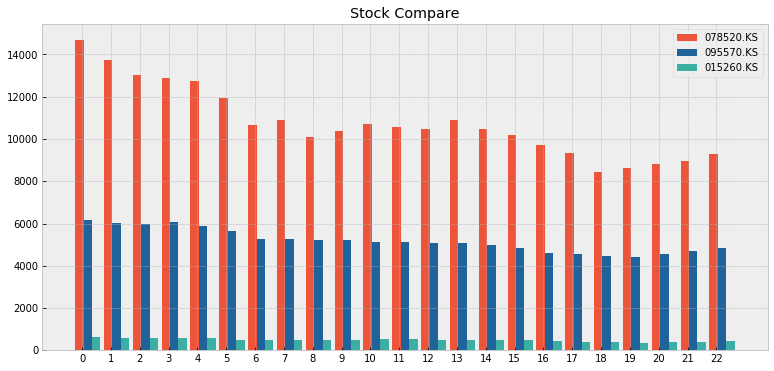

In [17]:
title = 'Stock Compare'
legend = np.array(df_data['code'].tolist())
sequence = np.concatenate([np.full(23,2), np.full(23, 0), np.full(23,1)])
x = np.array(df_data.index.tolist())
y = np.array(df_data['s_close'].tolist())
draw_bar_chart(x, y, title, legend, sequence, options)